# Program Description: Dataset Division (Module 8)

## Overview:
This module is responsible for preprocessing the generated CSV dataset, dividing the dataset into three subsets: **Train**, **Validation**, and **Test**. The division follows a common ratio of **7:2:1** (train:valid:test). The resulting subsets are saved in `.txt` format and stored in the `datasets` folder under the current working path. Additionally, a log file (`out_log.txt`) is created in the `prepare` folder, which records the size of each divided dataset.

## Key Steps:
 
1. **Dataset Division**:
   - The filtered dataset is randomly split into **Train**, **Validation**, and **Test** sets in a 7:2:1 ratio.
   
2. **Save Results**:
   - Each dataset subset (Train, Valid, Test) is saved in a `.txt` format inside the `datasets` folder, making it ready for further analysis or modeling.
   
3. **Logging**:
   - A log file (`out_log.txt`) is saved in the `prepare` folder, which includes details about the dataset sizes (number of samples in each subset) and any additional relevant information.

## Output:
- Three `.txt` files stored in the `datasets` folder:
  - **train.txt**: Contains the training samples.
  - **valid.txt**: Contains the validation samples.
  - **test.txt**: Contains the testing samples.
  
- **out_log.txt**: A log file that provides the size of each dataset (Train, Valid, Test) and any preprocessing information.

contacts：zhaohf@ihep.ac.cn

# Import libraries

In [1]:
import os
from os.path import join, splitext, split,basename
import sys 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from larch import Group
from larch.xafs import pre_edge
import math


# Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['pandas', 'numpy', 'sklearn', 'larch']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

pandas: 2.0.3
numpy: 1.23.5
sklearn: 1.3.2
larch: 0.9.76
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings
## `method`: Specifies the method used to calculate the label in the data to be processed.
## `load_path`: The input file or directory where the dataset is located.
## `features`: A list of feature data variables used for dividing the dataset.
## `label_types`: The label data selection from the input file.
## All processed data will be saved in the `datasets` file within the current foder.


In [3]:
# Define the method and the data load path
method = "JmolNN"
load_path = "/media/dell-hd/data1/datasets/Au-datasets"
# Define the data types (features) to be used
features = ['chi', 'xmu', 'rdf']
# Define the label types
label_types = ["cn", "cr"]
# Check if the load path exists
if os.path.exists(load_path):
    print(f"Directory '{load_path}' exists.")
else:
    raise FileNotFoundError(f"Directory '{load_path}' does not exist.")
# Create paths for preparing and saving data
prepare_path = os.path.join(load_path, f"prepare({method})")
save_data_path = os.path.join(load_path, f"datasets({method})")


File '/media/dell-hd/data1/datasets/Au-datasets' exists.


## `n`: The number of samples to be processed.
## `train_set`, `valid_set`, `test_set`: The ratios for dividing the dataset into training, validation, and test sets, respectively.


In [4]:
# Set the number of samples to preprocess
n = 5001
# Define the dataset split ratios for train, validation, and test sets
train_set = 0.7
valid_set = 0.2
test_set = 0.1
# Define the file suffix (extension)
suffix = ".txt"

In [5]:
# Generate paths for each data type and store in variables
for data_type in features:
    globals()[f"{data_type}_path"] = join(load_path, data_type)

# Construct label paths for the specified method
for label_type in label_types:
    globals()[f"{label_type}_label_path"] = join(load_path, f"{label_type}/{label_type}_{method}.csv")

excluded_indices_file = join(load_path, f"indices_to_move_{method}.csv")

# Create a dictionary to store paths, showing only common directory paths
for data_type in features:
    globals()[f"save_{data_type}_path"] = join(prepare_path, data_type)
for label_type in label_types:
    globals()[f"save_label_{label_type}"] = join(prepare_path, f"label_{label_type}.csv")

# Check and create necessary directories
paths_to_check = [prepare_path, save_data_path] + [globals()[f'save_{data_type}_path'] for data_type in features]
for path in paths_to_check:
    if not os.path.exists(path):
        os.makedirs(path)

# Create CSV files for labels if they do not exist
for label_type in label_types:
    label_csv_path = globals()[f'save_label_{label_type}']
    if not os.path.exists(label_csv_path):
        with open(label_csv_path, 'w'):
            pass  # Create an empty CSV file

# Store path information into a file
with open(join(prepare_path, "out_log.txt"), "w") as f:
    for label_type in label_types:
        f.write(f"Label Path ({label_type.upper()}): {globals()[f'{label_type}_label_path']}\n")
    f.write(f"Excluded Indices File Path: {excluded_indices_file}\n")
    f.write(f"Data Save Path: {save_data_path}\n\n")

    for data_type in features:
        f.write(f"{data_type} Data Path: {globals()[f'{data_type}_path']}\n")
        f.write(f"Save Path: {globals()[f'save_{data_type}_path']}\n")

    for label_type in label_types:
        f.write(f"Save Path (label_{label_type}): {globals()[f'save_label_{label_type}']}\n")
print("Path information has been stored in out_log.txt.")

# List files in the xmu directory and count the number of samples
xmu_files = os.listdir(xmu_path)
num_samples = len(xmu_files)
print(f"Total number of samples: {num_samples}")

Path information has been stored in out_log.txt.
Total number of samples: 5001


In [6]:
# Check and create necessary directories if they do not exist
for path in [prepare_path, save_data_path] + [globals()[f"save_{data_type}_path"] for data_type in features]:
    if not os.path.exists(path):
        os.makedirs(path)

# Read excluded indices if it exists
if os.path.exists(excluded_indices_file):
    excluded_indices = pd.read_csv(excluded_indices_file)["index"].tolist()
else:
    excluded_indices = []  # Initialize an empty list if the file does not exist

# Create empty label files if they do not exist
for label_type in label_types:
    save_label_file = globals()[f"save_label_{label_type}"]
    if not os.path.exists(save_label_file):
        pd.DataFrame(columns=["index", "value"]).to_csv(save_label_file, index=False)


# Function settings

In [7]:
# Define the function to read the data, read the chi spectrum data
# def get_chi(path, n=-1, save_path=False, plot=False):
#     plot_dat = None
#     chi = []
#     file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         if save_path:
#             dat.to_csv(join(save_path, basename(file)), index=False)
#         if index == plot:
#             plot_dat = dat
#         if dat.k[0] == 0:
#             dat = dat[1:]
#         chi.append((index, dat.chi.values))
#     chi.sort(key=lambda x: x[0])
#     chi = [x[1] for x in chi]
#     if plot:
#         fig, ax = plt.subplots(1, 1)
#         ax.plot(plot_dat.k, plot_dat.chi * (plot_dat.k ** 2))
#         plt.show()
#     return np.array(chi)
# # 定义读取数据的函数，读取xmu谱数据，并进行差分
# def get_xmu(path, n=-1, save_path=False, plot=False):
#     plot_dat = None
#     plot_dat_new = None
#     file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#     emin, emax = float('inf'), float('-inf')
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         if index == plot:
#             plot_dat = dat
#         dat = Group(energy=dat.energy, mu=dat.mu)
#         pre_edge(dat)
#         emin = min(emin, dat.e0)
#         emax = max(emax, dat.e0)
    
#     xmu = []
#     xvals = np.linspace(emin-10, emax+200, 1000)
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         yvals = np.interp(xvals, dat.energy, dat.mu)
#         if index == plot:
#             plot_dat_new = (xvals, yvals)
#         xmu.append((index, yvals))
#     xmu.sort(key=lambda x: x[0])
#     xmu = [x[1] for x in xmu]
#     if plot and plot_dat_new is not None:
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(plot_dat.energy, plot_dat.mu)
#         plt.subplot(1, 2, 2)
#         plt.plot(plot_dat_new[0], plot_dat_new[1])
#         plt.show()
#     if save_path:
#         for i, file in enumerate(file_list):
#             dat = pd.DataFrame({"energy": xvals, "mu": xmu[i]})
#             dat.to_csv(join(save_path, basename(file)), index=False)
#     return xmu
# # Define the function to read data and read norm spectrum data
# def get_norm(path, n=-1, save_path=False, plot=False):
#     plot_dat = None
#     plot_dat_new = None
#     file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#     emin, emax = float('inf'), float('-inf')
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         if index == plot:
#             plot_dat = dat
#         dat = Group(energy=dat.energy, mu=dat.norm)
#         pre_edge(dat)
#         emin = min(emin, dat.e0)
#         emax = max(emax, dat.e0)
    
#     norm = []
#     xvals = np.linspace(emin-30, emax+400, 500)
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         yvals = np.interp(xvals, dat.energy, dat.norm)
#         if index == plot:
#             plot_dat_new = (xvals, yvals)
#         norm.append((index, yvals))
#     norm.sort(key=lambda x: x[0])
#     norm = [x[1] for x in norm]
#     if plot and plot_dat_new is not None:
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         plt.plot(plot_dat.energy, plot_dat.norm)
#         plt.subplot(1, 2, 2)
#         plt.plot(plot_dat_new[0], plot_dat_new[1])
#         plt.show()
#     if save_path:
#         for i, file in enumerate(file_list):
#             dat = pd.DataFrame({"energy": xvals, "norm": norm[i]})
#             dat.to_csv(join(save_path, basename(file)), index=False)
#     return norm
# # Define the function to read data and read rdf data
# def get_rdf(path, n=-1, save_path=False, plot=False):
#     plot_dat = None
#     rdf = []
#     file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         if save_path:
#             dat.to_csv(join(save_path, basename(file)), index=False)
#         if index == plot:
#             plot_dat = dat
#         rdf.append((index, dat['g(r)'].values))
#     rdf.sort(key=lambda x: x[0])
#     rdf = [x[1] for x in rdf]
#     if plot and plot_dat is not None:
#         plt.figure(figsize=(10, 6))
#         plt.plot(plot_dat['r'], plot_dat['g(r)'])
#         plt.xlabel("r")
#         plt.ylabel("g(r)")
#         plt.title("RDF Plot")
#         plt.show()
#     return np.array(rdf)
# #Function to read wavelet change data
# def get_wt(path, rate=1200, n=40, save_path=False, plot=False):
#     if save_path:
#         save_path1, save_path2 = join(save_path, "1"), join(save_path, "2")
#         if not os.path.exists(save_path1):
#             os.makedirs(save_path1)
#         if not os.path.exists(save_path2):
#             os.makedirs(save_path2)
#     file_list = sorted(glob.glob(join(path, "*.csv")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#     dat = pd.read_csv(file_list[0])
#     k_list, r_list = sorted(list(set(dat.k.values))), sorted(list(set(dat.r.values)))
#     if 0 in k_list:
#         k_list.remove(0.0)
#     k_list, r_list = k_list[::math.ceil(len(k_list)/40)], r_list[::math.ceil(len(r_list)/40)]
    
#     wt = np.array([])
#     all_dat = []
#     for file in file_list:
#         index = int(splitext(basename(file))[0])
#         dat = pd.read_csv(file)
#         dat = dat[dat['k'].isin(k_list)]
#         dat = dat[dat['r'].isin(r_list)]
#         dat.index = range(len(dat))
#         all_dat.append(dat)
        
#         if save_path1:
#             dat.to_csv(join(save_path1, basename(file)), index=False)
#         if len(wt) == 0:
#             wt = dat.mag.values.reshape(1, -1)
#         else:
#             wt = np.concatenate((wt, dat.mag.values.reshape(1, -1)), axis=0)
    
#     var = np.var(wt, axis=0)
#     index_list = np.where(var > sorted(var, reverse=True)[rate])[0]
#     index_list_ = np.where(var <= sorted(var, reverse=True)[rate])[0]
#     new_wt = wt[:, index_list]
    
#     if plot:
#         plt.figure(figsize=(14, 6))
#         plt.subplot(1, 2, 1)
#         x, y = np.meshgrid(k_list, r_list)
#         z = wt[plot, :].reshape((33, 40))
#         plt.contourf(x, y, z, cmap=plt.cm.bwr, levels=40)
#         plt.xlabel(r'Wavenumber k $(\AA^{-1})$', fontsize=15)
#         plt.ylabel(r'Radial distance R $(\AA^{-1})$', fontsize=12)
#         plt.title("Wavelet Transform: Magnitude", fontsize=15)
        
#         plt.subplot(1, 2, 2)
#         x, y = np.meshgrid(k_list, r_list)
#         z = wt[plot, :]
#         z[[index_list_]] = 0
#         z = z.reshape((33, 40))
#         plt.contourf(x, y, z, cmap=plt.cm.bwr, levels=40)
#         plt.xlabel(r'Wavenumber k $(\AA^{-1})$', fontsize=15)
#         plt.ylabel(r'Radial distance R $(\AA^{-1})$', fontsize=12)
#         plt.title("Wavelet Transform: Magnitude", fontsize=15)
        
#         plt.show()
#     if save_path2:
#         for file, dat in zip(file_list, all_dat):
#             dat = dat.loc[index_list, :]
#             dat.index = range(len(dat))
#             dat.to_csv(join(save_path2, basename(file)), index=False)
#     return new_wt
# #Function to read wavelet change image
# class get_wt_pic(object):
#     def __init__(self, path, label, img_size=(256, 256), n=-1):
#         super().__init__()
#         self.file_list = sorted(glob.glob(join(path, "*.png")), key=lambda x: int(splitext(basename(x))[0]))[:n]
#         self.label = label
#         self.img_size = img_size

#     def __getitem__(self, index):
#         pic = Image.open(self.file_list[index])
#         pic = transforms.Resize(self.img_size)(pic)  
#         pic = transforms.ToTensor()(pic)
#         label = torch.Tensor([self.label[index]])
#         return pic[:3, :, :], label
        
#     def __len__(self):
#         return len(self.file_list)
# Function to read label data
def load_data(datadir, label_cn_path, label_cr_path, excluded_indices, min_label=0, max_label=np.inf):
    # Read label files
    label_cn_df = pd.read_csv(label_cn_path)
    label_cr_df = pd.read_csv(label_cr_path)

    # Filter out excluded samples
    label_cn_df = label_cn_df[~label_cn_df['index'].isin(excluded_indices)]
    label_cr_df = label_cr_df[~label_cr_df['index'].isin(excluded_indices)]

    # Sort by index
    label_cn_df.sort_values('index', inplace=True)
    label_cr_df.sort_values('index', inplace=True)

    # Extract label values
    label_cn = label_cn_df.iloc[:, 1].values
    label_cr = label_cr_df.iloc[:, 1].values

    # Get file list and sort by the index in the filename
    filelist = glob.glob(join(datadir, '*.csv'))
    if not filelist:
        print(f"No files found in {datadir}")
        return None, None, None
    filelist = sorted(filelist, key=lambda x: int(splitext(basename(x))[0]))

    data_list = []
    min_length = float('inf')
    for file in filelist:
        index = int(splitext(basename(file))[0])
        if index in excluded_indices:
            continue
        temp = pd.read_csv(file)
        temp_values = temp.iloc[:, 1].values  # Assuming data is in the second column
        min_length = min(min_length, len(temp_values))  # Find the shortest length
        data_list.append(temp_values)
    
    # Ensure all data lengths are consistent
    data_list = [data[:min_length] for data in data_list]
    data = np.vstack(data_list)
    
    # Ensure label lengths match the data
    min_length = min(len(data), len(label_cn), len(label_cr))
    data = data[:min_length]
    label_cn = label_cn[:min_length]
    label_cr = label_cr[:min_length]

    # Filter labels
    index = np.where((label_cn >= min_label) & (label_cn <= max_label))[0]
    
    return data[index], label_cn[index], label_cr[index]

#Function to divide the data set
def split_data(data, label_cn, label_cr, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1, random_seed=None):
    assert math.isclose(train_ratio + valid_ratio + test_ratio, 1.0), "The sum of the ratios must be 1"
    total_size = len(data)
    train_size = int(total_size * train_ratio)
    valid_size = int(total_size * valid_ratio)
    test_size = total_size - train_size - valid_size

    if random_seed is not None:
        np.random.seed(random_seed)

    indices = np.arange(total_size)
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    valid_indices = indices[train_size:train_size + valid_size]
    test_indices = indices[train_size + valid_size:]

    train_data, valid_data, test_data = data[train_indices], data[valid_indices], data[test_indices]
    train_label_cn, valid_label_cn, test_label_cn = label_cn[train_indices], label_cn[valid_indices], label_cn[test_indices]
    train_label_cr, valid_label_cr, test_label_cr = label_cr[train_indices], label_cr[valid_indices], label_cr[test_indices]

    return (train_data, train_label_cn, train_label_cr, train_indices), \
           (valid_data, valid_label_cn, valid_label_cr, valid_indices), \
           (test_data, test_label_cn, test_label_cr, test_indices)
#Function to save data
def save_dataset(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix, method, indices, set_type):
    file_feature = f"{feature}_{set_type}_{method}{suffix}"
    path_file_feature = os.path.join(path_data, file_feature)
    
    with open(path_file_feature, 'w') as fout:
        for i in indices:
            if i >= data_np_array.shape[0]:
                continue
            for j in range(data_np_array.shape[1]):
                fout.write(f"{data_np_array[i, j]:14.6e}")
            fout.write('\n')

    file_label_cn = f"label_cn_{set_type}_{method}{suffix}"
    path_file_label_cn = os.path.join(path_data, file_label_cn)
    with open(path_file_label_cn, 'w') as fout:
        for i in indices:
            if i >= label_cn_np_array.shape[0]:
                continue
            fout.write(f"{label_cn_np_array[i]:6.3f}\n")

    file_label_cr = f"label_cr_{set_type}_{method}{suffix}"
    path_file_label_cr = os.path.join(path_data, file_label_cr)
    with open(path_file_label_cr, 'w') as fout:
        for i in indices:
            if i >= label_cr_np_array.shape[0]:
                continue
            fout.write(f"{label_cr_np_array[i]:6.3f}\n")

def save_all(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix, method, train_indices, valid_indices, test_indices):
    if not os.path.exists(path_data):
        os.makedirs(path_data)

    save_dataset(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix, method, train_indices, 'train')
    save_dataset(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix, method, valid_indices, 'valid')
    save_dataset(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix, method, test_indices, 'test')

    # Function to save the complete dataset
    save_dataset(data_np_array, label_cn_np_array, label_cr_np_array, path_data, feature, suffix,f"{method}", np.arange(len(data_np_array)),'all')



In [8]:
label_cn = pd.read_csv(cn_label_path)[:n]
label_cr = pd.read_csv(cr_label_path)[:n]
label_cn.to_csv(save_label_cn, index=False)
print(f"label_cn finished")
label_cr.to_csv(save_label_cr, index=False)
print(f"label_cr finished")

label_cn finished
label_cr finished


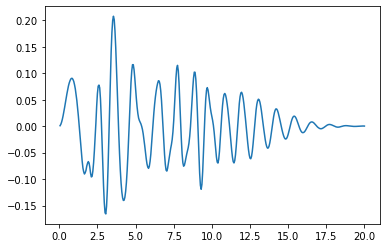

fature_chi finished


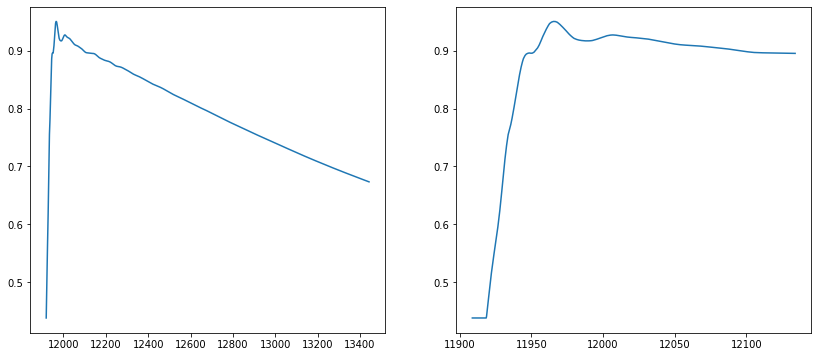

fature_xmu finished


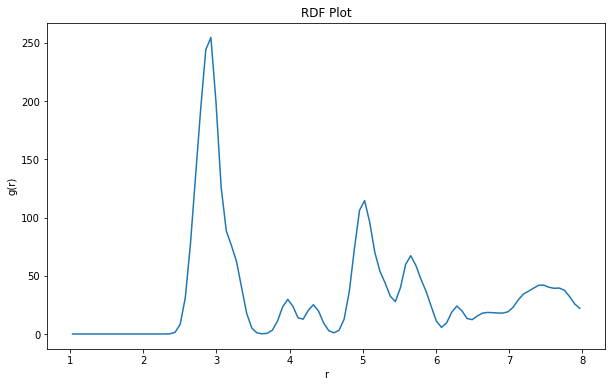

fature_rdf finished


In [9]:
# def process_data(features,n):
#     if 'chi' in features:
#         chi = get_chi(chi_path, save_path=save_chi_path, n=n, plot=1)
#         print(f"fature_chi finished")
#     if 'xmu' in features:
#         xmu = get_xmu(xmu_path, save_path=save_xmu_path, n=n, plot=1)
#         print(f"fature_xmu finished")
#     if 'norm' in features:
#         norm = get_norm(norm_path, save_path=save_norm_path, n=n, plot=1)
#         print(f"fature_norm finished")
#     if 'rdf' in features:
#         rdf = get_rdf(rdf_path, save_path=save_rdf_path, n=n, plot=1)
#         print(f"fature_rdf finished")
#     if 'wt' in features:
#         wt = get_wt(wt_path, n=n, save_path=save_wt_path, rate=150, plot=1)
#         print(f"fature_wt finished")
# process_data(features, n)

#   Main program

In [10]:
# Process feature data and append log information
for feature in features:
    datadir = os.path.join(prepare_path, feature)
    print(f"Processing feature: {feature} from {datadir}")
    
    # Load data
    data, label_cn, label_cr = load_data(datadir, save_label_cn, save_label_cr, excluded_indices, min_label=0)
    
    if data is not None and label_cn is not None and label_cr is not None:

        # Split and save data
        (train_data, train_label_cn, train_label_cr, train_indices), \
        (valid_data, valid_label_cn, valid_label_cr, valid_indices), \
        (test_data, test_label_cn, test_label_cr, test_indices) = split_data(
            data, label_cn, label_cr, train_ratio=train_set, valid_ratio=valid_set, test_ratio=test_set, random_seed=42
        )
        
        save_all(data, label_cn, label_cr, save_data_path, feature, suffix, method, train_indices, valid_indices, test_indices)
        print(f"Data shape: {data.shape}, Label CN shape: {label_cn.shape}, Label CR shape: {label_cr.shape}")
        print(f"Train data shape: {train_data.shape}, Train label CN shape: {train_label_cn.shape}, Train label CR shape: {train_label_cr.shape}\n")
        print(f"Valid data shape: {valid_data.shape}, Valid label CN shape: {valid_label_cn.shape}, Valid label CR shape: {valid_label_cr.shape}\n")
        print(f"Test data shape: {test_data.shape}, Test label CN shape: {test_label_cn.shape}, Test label CR shape: {test_label_cr.shape}\n")
        
        # Append log information
        with open(join(prepare_path, "out_log.txt"), "a") as f:
            f.write(f"\nProcessing feature: {feature}\n")
            f.write(f"Data shape: {data.shape}, Label CN shape: {label_cn.shape}, Label CR shape: {label_cr.shape}\n")
            f.write(f"Train data shape: {train_data.shape}, Train label CN shape: {train_label_cn.shape}, Train label CR shape: {train_label_cr.shape}\n")
            f.write(f"Valid data shape: {valid_data.shape}, Valid label CN shape: {valid_label_cn.shape}, Valid label CR shape: {valid_label_cr.shape}\n")
            f.write(f"Test data shape: {test_data.shape}, Test label CN shape: {test_label_cn.shape}, Test label CR shape: {test_label_cr.shape}\n")
            f.write("Data split and saved successfully.\n")
    else:
        print(f"Failed to load data for feature: {feature}")
        with open(join(prepare_path, "out_log.txt"), "a") as f:
            f.write(f"\nFailed to load data for feature: {feature}\n")


Processing feature: chi from /media/dell-hd/data1/datasets/Au-datasets/prepare(JmolNN)/chi
Data shape: (4920, 400), Label CN shape: (4920,), Label CR shape: (4920,)
Train data shape: (3444, 400), Train label CN shape: (3444,), Train label CR shape: (3444,)

Valid data shape: (984, 400), Valid label CN shape: (984,), Valid label CR shape: (984,)

Test data shape: (492, 400), Test label CN shape: (492,), Test label CR shape: (492,)

Processing feature: xmu from /media/dell-hd/data1/datasets/Au-datasets/prepare(JmolNN)/xmu
Data shape: (4920, 1000), Label CN shape: (4920,), Label CR shape: (4920,)
Train data shape: (3444, 1000), Train label CN shape: (3444,), Train label CR shape: (3444,)

Valid data shape: (984, 1000), Valid label CN shape: (984,), Valid label CR shape: (984,)

Test data shape: (492, 1000), Test label CN shape: (492,), Test label CR shape: (492,)

Processing feature: rdf from /media/dell-hd/data1/datasets/Au-datasets/prepare(JmolNN)/rdf
Data shape: (4920, 100), Label CN s